In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[2 0 1 2 1 0 0 2 0 0 1 0 1 1 0 2 2 0 1 0 2 2 2 0 2 1 1 2 1 0 1 0]


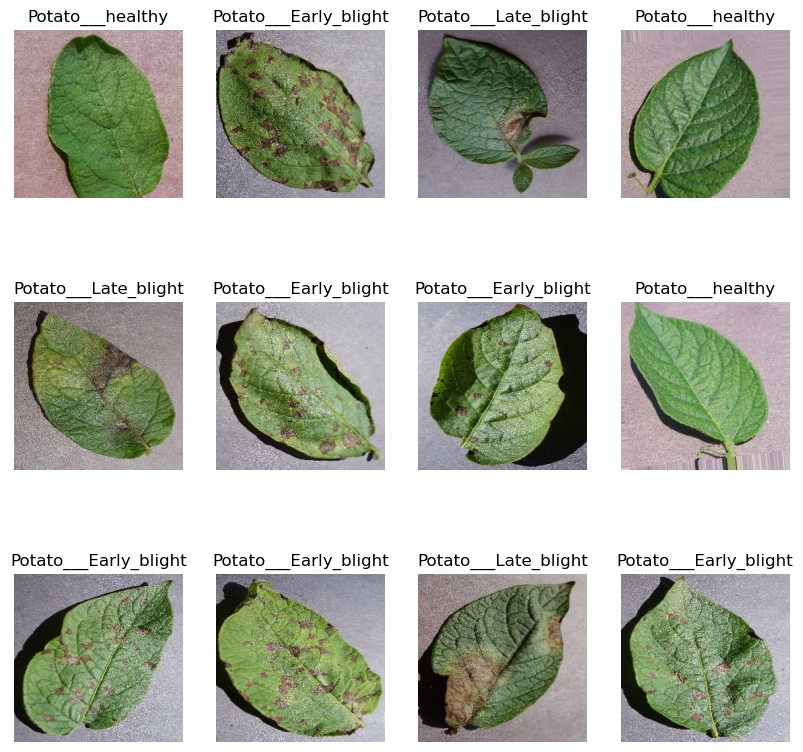

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

28 9 10


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
28/28 [==============================] - 35s 1s/step - loss: 1.0646 - accuracy: 0.3795 - val_loss: 0.8218 - val_accuracy: 0.6111
Epoch 2/20
28/28 [==============================] - 37s 1s/step - loss: 0.7238 - accuracy: 0.6529 - val_loss: 0.5490 - val_accuracy: 0.7639
Epoch 3/20
28/28 [==============================] - 36s 1s/step - loss: 0.5712 - accuracy: 0.7232 - val_loss: 0.5792 - val_accuracy: 0.7153
Epoch 4/20
28/28 [==============================] - 36s 1s/step - loss: 0.5006 - accuracy: 0.7790 - val_loss: 0.5920 - val_accuracy: 0.7326
Epoch 5/20
28/28 [==============================] - 37s 1s/step - loss: 0.4237 - accuracy: 0.7991 - val_loss: 0.4189 - val_accuracy: 0.8264
Epoch 6/20
28/28 [==============================] - 36s 1s/step - loss: 0.3899 - accuracy: 0.8426 - val_loss: 0.3685 - val_accuracy: 0.8576
Epoch 7/20
28/28 [==============================] - 36s 1s/step - loss: 0.3657 - accuracy: 0.8527 - val_loss: 0.3421 - val_accuracy: 0.8368
Epoch 8/20
28/28 [==

In [13]:
scores=model.evaluate(test_ds)
scores

10/10 [==============================] - 3s 221ms/step - loss: 0.1598 - accuracy: 0.9375


[0.15979883074760437, 0.9375]

In [14]:
history.history['loss']

[1.0645924806594849,
 0.7238253355026245,
 0.5711798667907715,
 0.5006385445594788,
 0.4236770570278168,
 0.38990989327430725,
 0.3656766414642334,
 0.3247925341129303,
 0.3096480965614319,
 0.27870407700538635,
 0.2544518709182739,
 0.2622733414173126,
 0.18614844977855682,
 0.22940652072429657,
 0.17498815059661865,
 0.1378176063299179,
 0.1826752871274948,
 0.13602492213249207,
 0.12122549116611481,
 0.1122792437672615]

In [15]:
history.history['accuracy']

[0.3794642984867096,
 0.6529017686843872,
 0.7232142686843872,
 0.7790178656578064,
 0.7991071343421936,
 0.8426339030265808,
 0.8526785969734192,
 0.8660714030265808,
 0.8649553656578064,
 0.8950892686843872,
 0.9029017686843872,
 0.8962053656578064,
 0.9341517686843872,
 0.9140625,
 0.9296875,
 0.9408482313156128,
 0.921875,
 0.9475446343421936,
 0.9642857313156128,
 0.9587053656578064]

In [16]:
history.history['val_loss']

[0.8218085169792175,
 0.5490176677703857,
 0.5791897773742676,
 0.5920097827911377,
 0.41891077160835266,
 0.36848965287208557,
 0.3420984447002411,
 0.30749738216400146,
 0.298359751701355,
 0.29404008388519287,
 0.29407182335853577,
 0.22386595606803894,
 0.23388256132602692,
 0.17700785398483276,
 0.1646694839000702,
 0.28406664729118347,
 0.19291608035564423,
 0.12048198282718658,
 0.14095161855220795,
 0.12944667041301727]

In [17]:
history.history['val_accuracy']

[0.6111111044883728,
 0.7638888955116272,
 0.7152777910232544,
 0.7326388955116272,
 0.8263888955116272,
 0.8576388955116272,
 0.8368055820465088,
 0.8819444179534912,
 0.8715277910232544,
 0.8888888955116272,
 0.875,
 0.9201388955116272,
 0.8958333134651184,
 0.9340277910232544,
 0.9375,
 0.9201388955116272,
 0.9166666865348816,
 0.9479166865348816,
 0.9618055820465088,
 0.9548611044883728]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

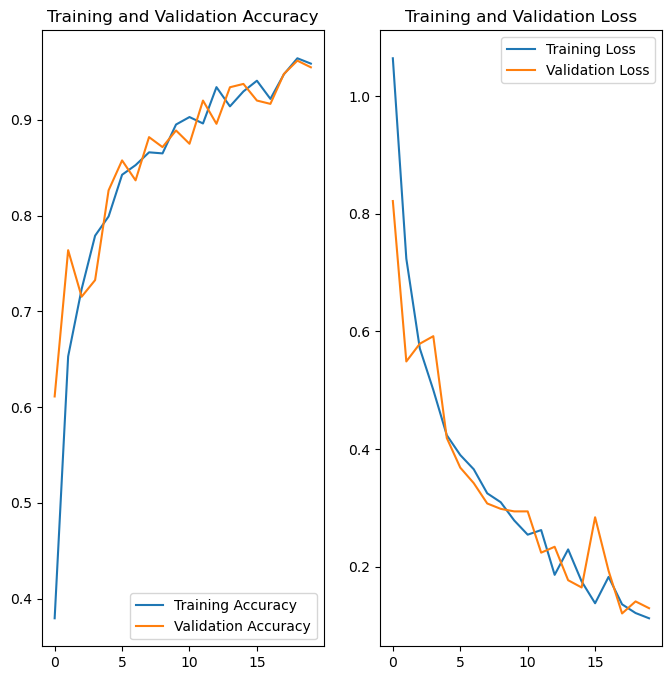

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [20]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(10):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 297ms/step


In [21]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


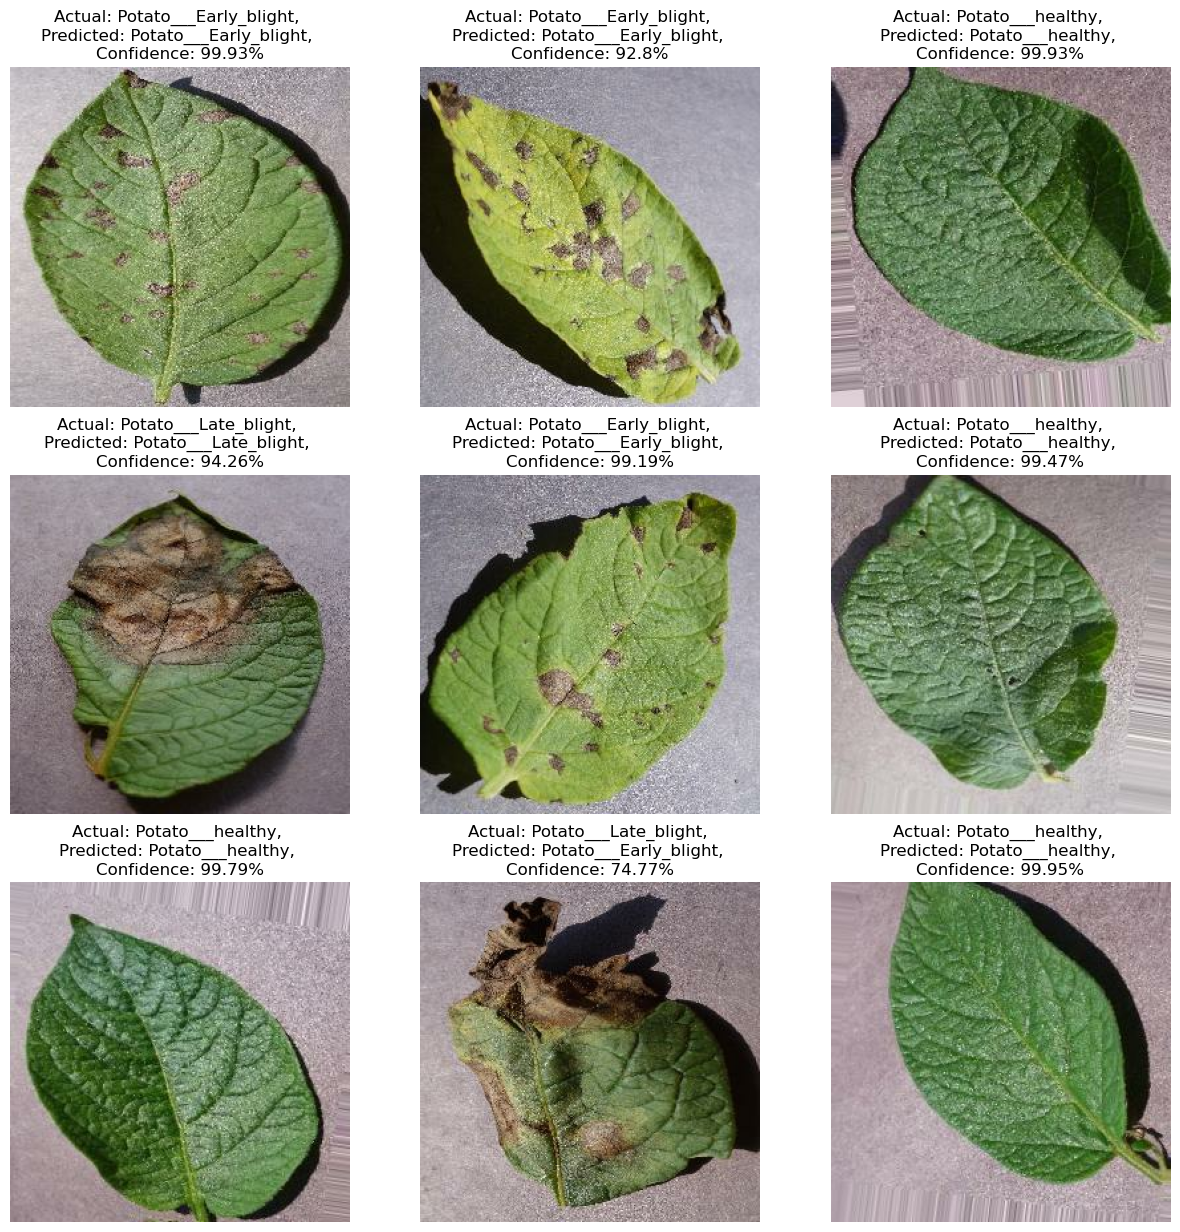

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [23]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      1.00      0.93       113
           1       1.00      0.81      0.89       103
           2       0.98      1.00      0.99       104

    accuracy                           0.94       320
   macro avg       0.95      0.94      0.94       320
weighted avg       0.95      0.94      0.94       320



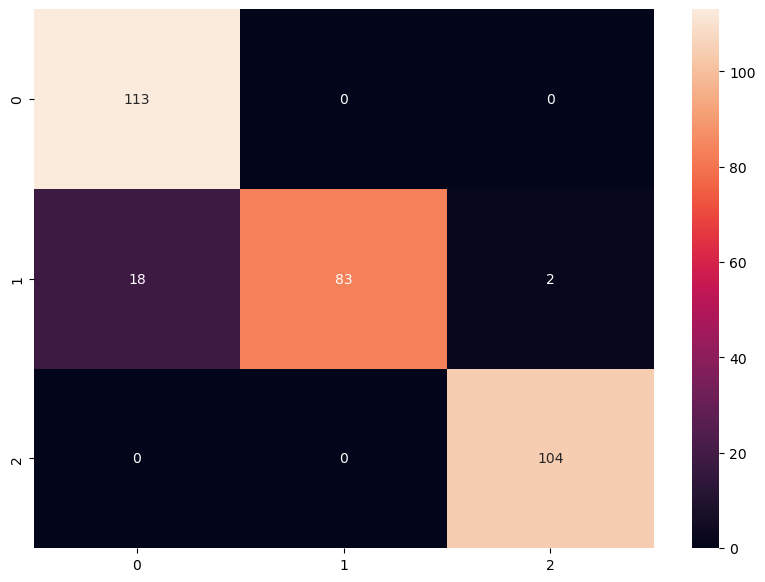

In [24]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [25]:
filename = "Model1-2-DatasetSplit60-20-20.joblib"
joblib.dump(model, filename)

['Model1-2-DatasetSplit60-20-20.joblib']